### use to browse images of cutouts in existing folders in order to select good nonlenses for a training set

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import glob
import os
import scipy
from astropy.io import fits
import importlib.util
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.backends.backend_pdf
import re
import copy
from astropy.visualization import make_lupton_rgb
import matplotlib.image as mpimg
import shutil
import wget

In [2]:
def browse(save_path, dl_csvfile, dl_fits, dl_jpegs, good_ims, start, next_keep, goal=1000):
    '''
    run this cell to sequentially browse images of cutouts (using fits and jpeg folders), select good nonlenses
    for a training set. enter '' (just hit enter) to save image and add to new folders/outfile. enter any other
    character to move on to next image without saving. enter 'keep *reason*' to append possible lenses or other
    objects to look at to another folder and npy file. enter "+n" to move forward n cutouts. enter 'exit' or 'quit' to save stuff and stop cell.
    
    returns: good_ims, start, next_keep (used to continue running same cell)
    
    '''
    
    # initiate arrays/files/folders if first run
    if not os.path.isdir(save_path):
        selected_ims = np.zeros((goal,))
        start = 0
        good_ims = 0
        next_keep = 0
        dict_empty = {'cutout':'none', 'ra':0, 'dec':0, 'reason':'none'} #dictionary of id, ra, dec, reason
        misc_arr = np.array([dict_empty]*1000, dtype=type(dict_empty))
        os.makedirs('{}misc_fits'.format(save_path))
        os.makedirs('{}misc_jpegs'.format(save_path))
        os.makedirs('{}selected_fits'.format(save_path))
        os.makedirs('{}selected_jpegs'.format(save_path))
        np.save('{}misc_idxs.npy'.format(save_path), misc_arr)
        np.save('{}selected_idxs.npy'.format(save_path), selected_ims)
    else:
        selected_ims = np.load('{}selected_idxs.npy'.format(save_path))
        misc_arr = np.load('{}misc_idxs.npy'.format(save_path))
    
    #temporary image for viewing
    image = np.zeros((3,101,101))
    
    jumpahead = False
    for j in range(start, goal):
        
        # skip ahead specified amount
        if jumpahead == True:
            if j == jumpstep:
                jumpahead = False
            continue
        
        # get ra/dec of each object and load its image 
        with open(dl_csvfile) as csvdata:
            objectinfo = [line.split(',') for line in csvdata]
            ra = objectinfo[j][3]
            dec = objectinfo[j][4]
        print('viewing cutout_{:06d}   ra = {}   dec = {}'.format(j, ra, dec))
        bands = fits.getdata('{}cutout_{:06d}.fits'.format(dl_fits,j))
        jpeg = mpimg.imread('{}cutout_{:06d}.jpeg'.format(dl_jpegs,j))
        
        #display the current image
        fig = plt.figure(figsize = (20,10))
        plt.subplot(141)
        plt.title('jpeg image')
        plt.imshow(jpeg, origin='lower')
        plt.subplot(142)
        plt.title('g')
        plt.imshow(bands[2]*4)
        plt.subplot(143)
        plt.title('r')
        plt.imshow(bands[1]*4)
        plt.subplot(144)
        plt.title('z')
        plt.imshow(bands[0]*4)
        plt.show()
        print('object {} ({} good objects so far)'.format(j,good_ims))
        decision = input('click enter to keep - anything else to move on:  ')
        plt.close(fig)
        
        #if input is empty it is approved
        if (decision == 'exit') or (decision == 'quit'): # exit program
            print('saving image IDs...')
            np.save('{}selected_idxs.npy'.format(save_path), selected_ims)
            print('\n*user exit*\n{} good objects\nstopped at index: {}\n{} further kept objects'.format(good_ims, j, next_keep))
            start = j
            return good_ims, start, next_keep
            
        elif (decision[:1] == '+'): # to skip ahead a specified amount of cutouts
            gotit=False
            while not gotit:
                try:
                    jumpstep = int(decision[1:]) + j - 1
                    gotit=True
                except:
                    decision = input('not a valid step amount - please retry command: ')
            jumpahead = True
            try:
                jumpstep = int(decision[1:]) + j - 1
            except:
                gotit=False
                while not gotit:
                    jumpstep = int()
            continue
        
        # to be investigated later - save cutout index and add jpeg to folder for viewing
        elif (decision[:4] == 'keep'):
            reason = decision[4:]
            misc_arr[next_keep] = {'cutout':'cutout_{:06d}'.format(j), 'ra':ra, 'dec':dec, 'reason':reason}
            np.save('{}misc_idxs.npy'.format(save_path), misc_arr)
            shutil.copy2('{}cutout_{:06d}.jpeg'.format(dl_jpegs,j), '{}misc_jpegs/misc_cutout_{:06d}.jpeg'.format(save_path,j))
            shutil.copy2('{}cutout_{:06d}.fits'.format(dl_fits,j), '{}misc_fits/misc_cutout_{:06d}.fits'.format(save_path,j))
            next_keep += 1
            start = j
            
        # to select - save cutout index and add jpeg to folder for viewing  
        elif (decision == ''):
            good_ims += 1
            selected_ims[good_ims-1] = j
            np.save('{}selected_idxs.npy'.format(save_path), selected_ims)
            shutil.copy2('{}cutout_{:06d}.jpeg'.format(dl_jpegs,j), '{}selected_jpegs/selected_cutout_{:06d}.jpeg'.format(save_path,j))
            shutil.copy2('{}cutout_{:06d}.fits'.format(dl_fits,j), '{}selected_fits/selected_cutout_{:06d}.fits'.format(save_path,j))
            start = j
        

In [3]:
# use to continue browsing and appending to existing npy files
start = 0
good_ims = 0
next_keep = 0

viewing cutout_000004   ra = 9.878961160759486   dec = -9.378775841682451


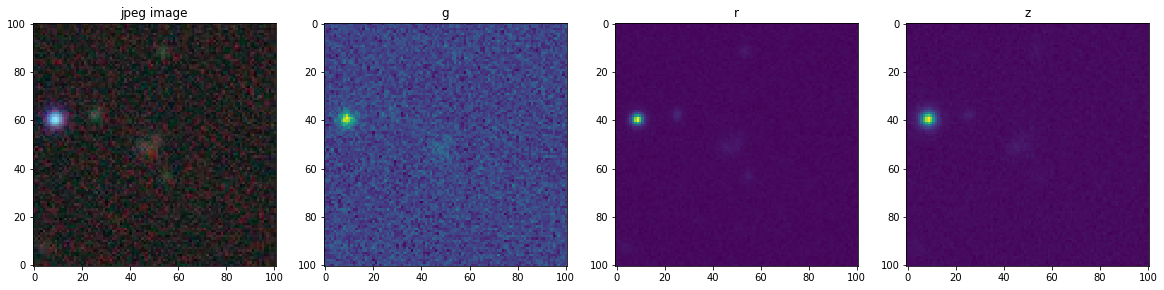

object 4 (4 good objects so far)
click enter to keep - anything else to move on:  '
viewing cutout_000005   ra = 9.919956654451957   dec = -9.378696120898034


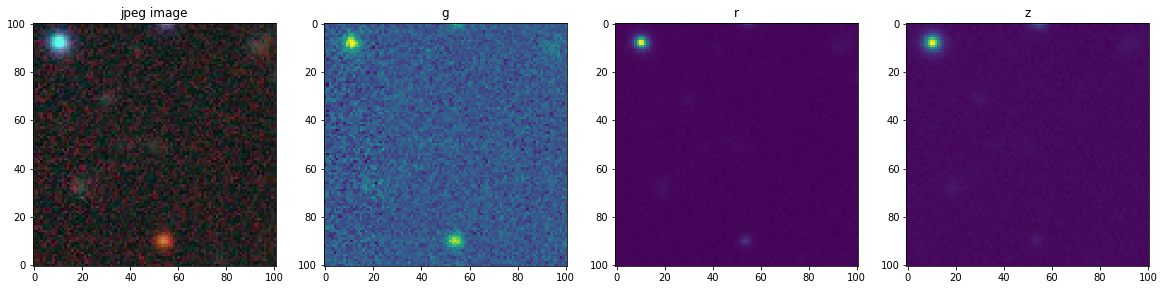

object 5 (4 good objects so far)
click enter to keep - anything else to move on:  
viewing cutout_000006   ra = 9.923339383270465   dec = -9.375622656829968


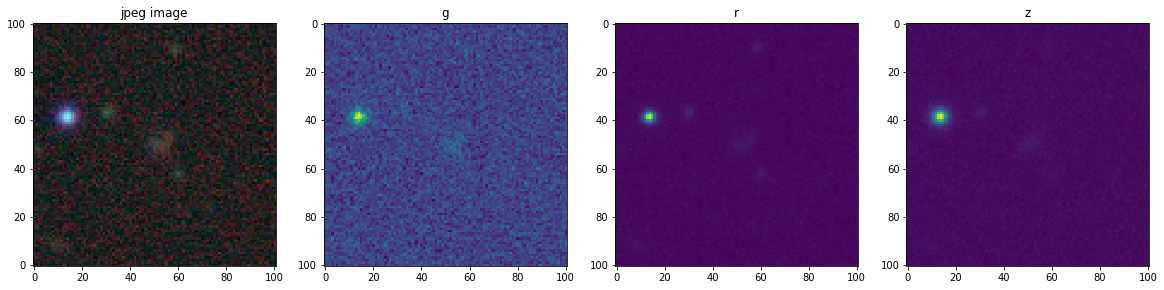

object 6 (5 good objects so far)
click enter to keep - anything else to move on:  exit
saving image IDs...

*user exit*
5 good objects
stopped at index: 6
1 further kept objects


In [8]:
dl_csvfile = 'C:/Users/mcdom/Documents/usf/lbnl/data/dr7/objectinfo_dr7.csv' # browsing image info catalog
dl_fits = 'C:/Users/mcdom/Documents/usf/lbnl/data/dr7/cutouts/'
dl_jpegs = 'C:/Users/mcdom/Documents/usf/lbnl/data/dr7/jpegs_dr7_NONLENS_CANDIDATES/'
save_path = 'C:/Users/mcdom/Documents/usf/lbnl/data/dr7/save_path/'

good_ims, start, next_keep = browse(save_path, dl_csvfile, dl_fits, dl_jpegs, good_ims, start, next_keep, goal=1000)

viewing cutout_000006   ra = 9.923339383270465   dec = -9.375622656829968


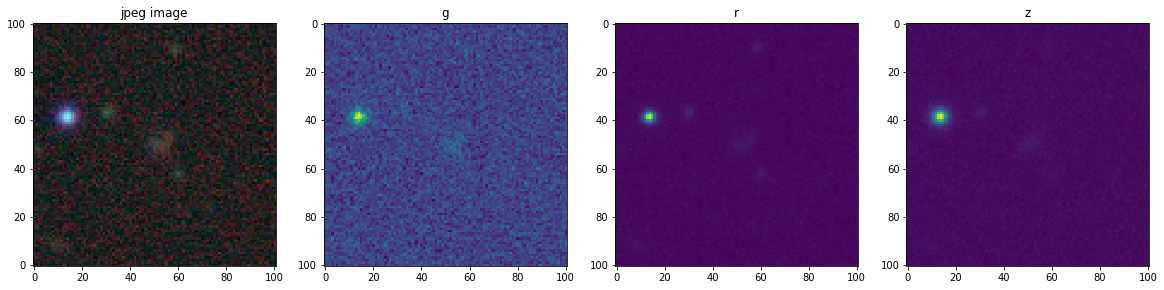

object 6 (5 good objects so far)
click enter to keep - anything else to move on:  


NameError: name 'selected_ims' is not defined

In [9]:
'''
run this cell to sequentially browse images of cutouts (using fits and jpeg folders), select good nonlenses
for a training set. enter '' (just hit enter) to save image and add to new folders/outfile. enter any other
character to move on to next image without saving. enter 'keep *reason*' to append possible lenses or other
objects to look at to another folder and npy file. enter 'exit' or 'quit' to save stuff and stop cell.

REMEMBER: change folder names --> more comprehensive (quality_nonlenses,quality_nonlenses _candidates, etc)

'''

# initialize variables
image = np.zeros((3,101,101)) #temporary image for viewing
dr = 7
csvfile = 'C:/Users/mcdom/Documents/usf/lbnl/data/dr7/objectinfo_dr7.csv'
jumpahead = False
# load nonlens images 
for j in range(start, 10000):
    # skip ahead specified amount
    if jumpahead == True:
        if j == jumpstep:
            jumpahead = False
        continue
        
    with open(csvfile) as csvdata:
        objectinfo = [line.split(',') for line in csvdata]
        ra = objectinfo[j][3]
        dec = objectinfo[j][4]
    print('viewing cutout_{:06d}   ra = {}   dec = {}'.format(j, ra, dec))
    image = fits.getdata('C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/cutouts/cutout_{:06d}.fits'.format(dr,j))
    jpeg = mpimg.imread('C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/jpegs_dr{}_NONLENS_CANDIDATES/cutout_{:06d}.jpeg'.format(dr,dr,j))
    #display the current image
    fig = plt.figure(figsize = (20,10))
    plt.subplot(141)
    plt.title('jpeg image')
    plt.imshow(jpeg, origin='lower')
    plt.subplot(142)
    plt.title('g')
    plt.imshow(image[2]*4)
    plt.subplot(143)
    plt.title('r')
    plt.imshow(image[1]*4)
    plt.subplot(144)
    plt.title('z')
    plt.imshow(image[0]*4)
    plt.show()
    print('object {} ({} good objects so far)'.format(j,good_ims))
    decision = input('click enter to keep - anything else to move on:  ')
    plt.close(fig)
    #if input is empty it is approved
    if (decision == 'exit') or (decision == 'quit'): # exit program
        print('saving image IDs...')
#         np.save('C:/Users/mcdom/Documents/usf/lbnl/data/dr6/selected_mzls_nonlense_id.npy', selected_ims) # DR6
        np.save('C:/Users/mcdom/Documents/usf/lbnl/data/dr7/save_path/selected_idxs.npy', selected_ims) # DR7
        print('\n*user exit*\n{} good objects\nstopped at index: {}\n{} further kept objects'.format(good_ims, j, next_keep))
        start = j
        break
    elif (decision[:1] == '+'): # to skip ahead a specified amount of cutouts
        gotit=False
        while not gotit:
            try:
                jumpstep = int(decision[1:]) + j - 1
                gotit=True
            except:
                decision = input('not a valid step amount - please retry command: ')
        jumpahead = True
        try:
            jumpstep = int(decision[1:]) + j - 1
        except:
            gotit=False
            while not gotit:
                jumpstep = int()
        continue
    elif (decision[:4] == 'keep'): # to be investigated later - save cutout index and add jpeg to folder for viewing
        reason = decision[4:]
        dict_arr[next_keep] = {'cutout':'cutout_{:06d}'.format(j), 'ra':ra, 'dec':dec, 'reason':reason}
        np.save('C:/Users/mcdom/Documents/usf/lbnl/data/dr7/kept_decals_nonlenses_CDE.npy',dict_arr)
        shutil.copy2('C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/jpegs_dr{}_NONLENS_CANDIDATES/cutout_{:06d}.jpeg'.format(dr,dr,j), 'C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/kept_decals_nonlenses_check_CDE/check_decals_nonlens_{:06d}.jpeg'.format(dr,j))
        next_keep += 1
        start = j
    elif (decision == ''): # to select - save cutout index and add jpeg to folder for viewing
        good_ims += 1
        selected_ims[good_ims-1] = j
        np.save('C:/Users/mcdom/Documents/usf/lbnl/data/dr7/save_path/selected_idxs.npy', selected_ims) # DR7
        shutil.copy2('C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/jpegs_dr{}_NONLENS_CANDIDATES/cutout_{:06d}.jpeg'.format(dr,dr,j), 'C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/selected_decals_nonlenses_jpegs_CDE/selected_decals_nonlens_{:06d}.jpeg'.format(dr,j))
        start = j

In [ ]:
'''
Use this to view jpeg and band images for the kept_decals_nonlenses cutouts.

'''

keeparrs = np.load('C:/Users/mcdom/Documents/usf/lbnl/data/dr7/save_path/selected_idxs.npy')
idx = 0
kept = 6
dr = 7
exit = False
while exit == False and idx < kept:
    arr = keeparrs[idx]
    cutout = arr['cutout']
    image = fits.getdata('C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/cutouts/{}.fits'.format(dr,cutout))
    jpeg = mpimg.imread('C:/Users/mcdom/Documents/usf/lbnl/data/dr{}/jpegs_dr{}_NONLENS_CANDIDATES/{}.jpeg'.format(dr,dr,cutout))
    #display the current image
    fig = plt.figure(figsize = (20,10))
    plt.subplot(141)
    plt.title('jpeg image')
    plt.imshow(jpeg, origin='lower')
    plt.subplot(142)
    plt.title('g')
    plt.imshow(image[2]*4)
    plt.subplot(143)
    plt.title('r')
    plt.imshow(image[1]*4)
    plt.subplot(144)
    plt.title('z')
    plt.imshow(image[0]*4)
    plt.show()
    print('[{}/{}] viewing {}   ra = {}   dec = {}'.format(idx+1, kept, cutout, arr['ra'], arr['dec']))
    print('COMMENT: {}'.format(arr['reason']))
    enter = input('enter \'exit\' to quit\n      \'reason *comment*\' to change comment and go to next kept object\n      anything else to go to next kept object: ')
    if enter == 'exit':
        print('exiting...')
        exit = True
    elif enter[:6] == 'reason':
        arr['reason'] = enter[7:]
        np.save('C:/Users/mcdom/Documents/usf/lbnl/data/dr7/save_path/kept_decals_nonlenses_CDE.npy', keeparrs)
        idx += 1
    else:
        idx += 1
        if idx == kept:
            print('viewed {}/{} kept images - exiting...\n'.format(kept,kept))
        continue

In [ ]:
indices = np.load('C:/Users/mcdom/Documents/usf/lbnl/data/dr7/save_path/selected_idxs.npy')
indices[90:110].astype(int)

In [ ]:
dicts = np.load('C:/Users/mcdom/Documents/usf/lbnl/data/dr7/save_path/misc_idxs.npy')
dicts[:5]